<a href="https://colab.research.google.com/github/gerardPlanella/path_explain/blob/master/torch_explain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Torch

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from path_explain import PathExplainerTorch, text_plot

# model = AutoModelForCausalLM.from_pretrained("distilgpt2")
# tokenizer = AutoTokenizer.from_pretrained("distilgpt2")


def embedding_model(batch_ids):
    batch_embedding = model.transformer.wte.weight[[batch_ids]]
    return batch_embedding


def prediction_model(batch_embedding):
    if batch_embedding.ndim == 2:
        batch_embedding = batch_embedding.unsqueeze(0)
    logits = model(inputs_embeds=batch_embedding).logits[:, -1]
    probs = torch.log_softmax(logits, dim=-1)

    return probs


# sen = "The nurse lost her keys , because"
sen = "The man"
out = "walks"

batch_input = tokenizer([sen])
batch_ids = batch_input['input_ids']
batch_embedding = embedding_model(batch_ids)

baseline_embedding = torch.zeros_like(batch_embedding)

output_idx = torch.tensor([tokenizer.convert_tokens_to_ids(f"Ġ{out}")])

explainer = PathExplainerTorch(prediction_model)
attributions = explainer.attributions(
    batch_embedding,
    baseline_embedding,
    output_indices=output_idx,
    num_samples=9,
    use_expectation=False,
)

sum_attr = attributions.squeeze().detach().numpy().sum(-1)

logit = prediction_model(batch_embedding)[0, output_idx].item()
baseline_output = prediction_model(baseline_embedding)[0, output_idx].item()

print("logit", logit)
print("attributions", sum_attr)
print("sum", sum(sum_attr))
print("diff", logit - baseline_output)

text_plot(
    sen.split(),
    sum_attr,
)


# The nurse lost his keys , because

# she: -1.76
# attributions [-0.13357379  1.862026    1.1488299   0.6746906   0.2510032   0.14159869
#   2.2729697 ]
# sum 6.217544347047806
# diff 7.994036674499512

# he: -1.27
# attributions [-0.76138175 -0.5459689   0.43218994  1.1869467  -0.29129577  0.56348467
#   3.0858443 ]
# sum 3.6698192358016968
# diff 4.965544700622559

# her -> she: -0.862424910068512
# her -> he:  -3.92

logit -6.8292555809021
attributions [0.7264259 3.1599007]
sum 3.886326551437378
diff 4.461550235748291


In [ ]:
# !/usr/bin/env python
import functools
import operator
import torch
from torch.autograd import grad
import numpy as np
import random
from tqdm import *

import sys

sys.path.append("../..")
sys.path.append("../path_explain/")

from diagnnose.models import import_model
from transformers import AutoModelForCausalLM, AutoTokenizer
from path_explain import text_plot


def gather_nd(params, indices):
    """
    Args:
        params: Tensor to index
        indices: k-dimension tensor of integers.
    Returns:
        output: 1-dimensional tensor of elements of ``params``, where
            output[i] = params[i][indices[i]]

            params   indices   output

            1 2       1 1       4
            3 4       2 0 ----> 5
            5 6       0 0       1
    """
    max_value = functools.reduce(operator.mul, list(params.size())) - 1
    indices = indices.t().long()
    ndim = indices.size(0)
    idx = torch.zeros_like(indices[0]).long()
    m = 1

    for i in range(ndim)[::-1]:
        idx += indices[i] * m
        m *= params.size(i)

    idx[idx < 0] = 0
    idx[idx > max_value] = 0
    return torch.take(params, idx)


class PathExplainerTorch(object):
    def __init__(self, model):
        self.model = model
        return

    def _get_ref_tensor(self, baseline, batch_size, num_samples):
        number_to_draw = num_samples * batch_size
        replace = baseline.shape[0] < number_to_draw
        sample_indices = np.random.choice(
            baseline.shape[0], size=number_to_draw, replace=replace
        )
        ref_tensor = baseline[sample_indices, :]

        return ref_tensor

    def _get_samples_delta(self, input_tensor, reference_tensor):
        input_expand_mult = input_tensor.unsqueeze(1)
        sd = input_expand_mult - reference_tensor
        return sd

    def _get_grads(self, samples_input, output_indices=None):

        grad_tensor = torch.zeros(samples_input.shape).float().to(samples_input.device)

        k_ = samples_input.shape[1]

        for i in range(k_):
            particular_slice = samples_input[:, i]
            batch_output = self.model(particular_slice)
            # should check that users pass in sparse labels
            # Only look at the user-specified label
            if batch_output.size(1) > 1:
                sample_indices = torch.arange(0, batch_output.size(0)).to(
                    samples_input.device
                )
                indices_tensor = torch.cat(
                    [sample_indices.unsqueeze(1), output_indices.unsqueeze(1)], dim=1
                )
                batch_output = gather_nd(batch_output, indices_tensor)

            model_grads = grad(
                outputs=batch_output,
                inputs=particular_slice,
                grad_outputs=torch.ones_like(batch_output).to(samples_input.device),
                create_graph=True,
            )
            grad_tensor[:, i, :] = model_grads[0]
        return grad_tensor

    def attributions(
        self,
        input_tensor,
        baseline,
        num_samples=50,
        use_expectation=True,
        output_indices=None,
        uniform_interpolate=False,
        gauss_legendre=False,
    ):
        """
        Calculate either Expected or Integrated Gradients approximation of
        Aumann-Shapley values for the sample ``input_tensor``.

        Args:
            model (torch.nn.Module): Pytorch neural network model for which the
                output should be explained.
            input_tensor (torch.Tensor): Pytorch tensor representing the input
                to be explained.
            baseline (torch.Tensor): Pytorch tensor representing the baseline.
                If use_expectation is true, then baseline should be shape
                (num_refs, ...) where ... indicates the dimensionality
                of the input. Otherwise, baseline should be shape (1, ...).
            output_indices (optional, default=None): For multi-class prediction
        """
        equal_dims = baseline.shape[1:] == input_tensor.shape[1:]
        almost_equal_dims = baseline.shape == input_tensor.shape[1:]

        dev = input_tensor.device
        baseline = baseline.to(dev)

        if not input_tensor.requires_grad:
            input_tensor.requires_grad = True

        if use_expectation and not equal_dims:
            raise ValueError(
                "baseline should be shape (num_refs, ...) \
                              where ... indicates the dimensionality   \
                              of the input"
            )

        if not use_expectation and baseline.shape[0] != 1:
            if almost_equal_dims:
                baseline = baseline.unsqueeze(0)
            else:
                raise ValueError(
                    "baseline should be shape (...)           \
                                  where ... indicates the dimensionality   \
                                  of the input"
                )

        samples_input, samples_delta, weights = self._get_samples_input(
            input_tensor,
            baseline,
            num_samples,
            use_expectation,
            uniform_interpolate,
            gauss_legendre,
        )

        grad_tensor = self._get_grads(samples_input, output_indices)
        mult_grads = samples_delta * grad_tensor

        # Weighted average over the interpolation dimension (1)
        # weights: (1, num_samples, 1, 1) (gauss_legendre weights)
        # mult_grads: (bsz, num_samples, sen_len, nhid)
        attributions = (mult_grads * weights).sum(1)

        return attributions

    def interactions(
        self,
        input_tensor,
        baseline,
        num_samples=50,
        use_expectation=True,
        output_indices=None,
        interaction_index=None,
        verbose=True,
        uniform_interpolate=False,
        gauss_legendre=False,
    ):
        equal_dims = baseline.shape[1:] == input_tensor.shape[1:]
        almost_equal_dims = baseline.shape == input_tensor.shape[1:]

        if use_expectation and not equal_dims:
            raise ValueError(
                "baseline should be shape (num_refs, ...) \
                              where ... indicates the dimensionality   \
                              of the input"
            )

        if not use_expectation and baseline.shape[0] != 1:
            if almost_equal_dims:
                baseline = baseline.unsqueeze(0)
            else:
                raise ValueError(
                    "baseline should be shape (...)           \
                                  where ... indicates the dimensionality   \
                                  of the input"
                )

        inner_loop_nsamples = int(round(np.sqrt(num_samples)))

        # (batch_size, inner_loop_nsamples, sen_len, nhid)
        samples_input, samples_delta, weights = self._get_samples_input(
            input_tensor,
            baseline,
            inner_loop_nsamples,
            use_expectation,
            uniform_interpolate=uniform_interpolate,
        )

        if interaction_index is not None:
            interaction_mult_tensor = torch.zeros(
                [input_tensor.size(1), samples_input.size(1), input_tensor.size(2)]
            )
        else:
            # (batch_size, inner_loop_nsamples, sen_len, sen_len, nhid)
            interaction_mult_tensor = torch.zeros(
                [
                    input_tensor.size(0),
                    samples_input.size(1),
                    input_tensor.size(1),
                    input_tensor.size(1),
                    input_tensor.size(2),
                ]
            )


        if use_expectation:
            loop_num = inner_loop_nsamples
        else:
            loop_num = inner_loop_nsamples  # + 1

        if verbose:
            iterable = tqdm(range(loop_num))
        else:
            iterable = range(loop_num)

        # i ranges over loop_num (=inner_loop_nsamples = sqrt(num_samples))
        for i in iterable:
            # (batch_size, sen_len, nhid)  <-- single interpolation point
            particular_slice = samples_input[:, i]
            # (batch_size, sen_len, nhid)  <-- emb.-level attributions to output_indices
            attributions = self.attributions(
                particular_slice,
                baseline,
                num_samples=inner_loop_nsamples,
                use_expectation=use_expectation,
                output_indices=output_indices,
                uniform_interpolate=uniform_interpolate,
                gauss_legendre=gauss_legendre,
            )

            if interaction_index is not None:
                second_grads = grad(
                    outputs=attributions[:, interaction_index],
                    inputs=particular_slice,
                    grad_outputs=torch.ones_like(attributions[:, interaction_index]),
                    create_graph=True,
                )[0]
                interaction_mult_tensor[:, i, :] = second_grads

            else:
                for feature in range(input_tensor.size(1)):
                    # (batch_size, sen_len, nhid)  <-- attributions to IG value of feature
                    second_grads = grad(
                        outputs=attributions[:, feature],
                        inputs=particular_slice,
                        grad_outputs=torch.ones_like(attributions[:, feature]),
                        create_graph=True,
                    )[0]
                    # i ranges over sqrt(num_samples)?
                    # feature ranges over sen_len
                    interaction_mult_tensor[:, i, feature, :, :] = second_grads.detach()

        interaction_mult_tensor = interaction_mult_tensor.to(samples_delta.device)
        if interaction_index is not None:
            interaction_tensor = interaction_mult_tensor * samples_delta
        else:
            # samples_delta : (batch_size, 1, sen_len, nhid)
            # interaction_mult_tensor : (batch_size, inner_loop, sen_len, sen_len, nhid)
            interaction_tensor = interaction_mult_tensor * samples_delta.unsqueeze(3)

        # (weighted) mean over inner_loop_nsamples
        interactions = (interaction_tensor * weights.unsqueeze(-1)).sum(1)

        # interactions are not summed yet over the embedding dimension!
        return interactions

    def _get_samples_input(
        self,
        input_tensor,
        baseline,
        num_samples,
        use_expectation,
        uniform_interpolate=False,
        gauss_legendre=False,
    ):
        """
        calculate interpolation points
        Args:
            input_tensor: Tensor of shape (batch, ...), where ... indicates
                          the input dimensions.
            reference_tensor: A tensor of shape (batch, k, ...) where ...
                indicates dimensions, and k represents the number of background
                reference samples to draw per input in the batch.
        Returns:
            samples_input: A tensor of shape (batch, k, ...) with the
                interpolated points between input and ref.
            samples_delta: A tensor of shape (batch, 1, ...) with the
                difference between input and reference for each sample
        """
        input_dims = list(input_tensor.size())[1:]
        num_input_dims = len(input_dims)
        batch_size = input_tensor.size()[0]

        if use_expectation and uniform_interpolate:
            num_baselines = baseline.size(0)
            assert num_samples > num_baselines
            num_interpolations = num_samples // num_baselines
            reference_tensor = torch.tile(baseline, (num_interpolations, 1, 1))
            t_tensor = torch.tensor(
                [
                    [
                        (float(i) / (num_interpolations - 1))
                        for i in range(num_interpolations)
                        for _ in range(num_baselines)
                    ]
                ]
                * batch_size
            )

        if use_expectation and not uniform_interpolate:
            reference_tensor = self._get_ref_tensor(baseline, batch_size, num_samples)
            shape = reference_tensor.shape
            reference_tensor = reference_tensor.view(
                batch_size, num_samples, *(shape[1:])
            )
            t_tensor = (
                torch.FloatTensor(batch_size, num_samples)
                .uniform_(0, 1)
                .to(reference_tensor.device)
            )

        weights = torch.tensor([1 / num_samples for i in range(num_samples)])

        if use_expectation:
            shape = [batch_size, num_samples] + [1] * num_input_dims
            interp_coef = t_tensor.view(*shape)

            # Evaluate the end points
            end_point_ref = (1.0 - interp_coef) * reference_tensor

            input_expand_mult = input_tensor.unsqueeze(1)
            end_point_input = interp_coef * input_expand_mult

            # Affine Combine
            samples_input = end_point_input + end_point_ref
        else:
            batch_size = input_tensor.size()[0]
            input_expand = input_tensor.unsqueeze(1)
            reps = np.ones(len(baseline.shape)).astype(int)
            reps[0] = batch_size
            reference_tensor = baseline.repeat(list(reps)).unsqueeze(1)

            if gauss_legendre:
                x, w = np.polynomial.legendre.leggauss(num_samples)
                alphas = list(0.5 * (1 + x))
                weights = torch.tensor(0.5 * w)
                weights /= weights.sum()
            else:
                alphas = [(float(i) / (num_samples - 1)) for i in range(num_samples)]

            scaled_inputs = [
                reference_tensor + alpha * (input_expand - reference_tensor)
                for alpha in alphas
            ]

            samples_input = torch.cat(scaled_inputs, dim=1)

        samples_delta = self._get_samples_delta(input_tensor, reference_tensor)
        samples_delta = samples_delta.to(samples_input.device)
        samples_weights = weights.view(1, -1, 1, 1)

        return samples_input, samples_delta, samples_weights


model = AutoModelForCausalLM.from_pretrained("distilgpt2")
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")


def embedding_model(batch_ids):
    batch_embedding = model.transformer.wte.weight[[batch_ids]]
    return batch_embedding


def prediction_model(batch_embedding):
    logits = model(inputs_embeds=batch_embedding).logits[:, -1]
    probs = torch.log_softmax(logits, dim=-1)

    return probs


sen = "They call New York the big"
out = "apple"

batch_input = tokenizer([sen])
batch_ids = batch_input['input_ids']
batch_embedding = embedding_model(batch_ids)

baseline_embedding = torch.zeros_like(batch_embedding)

output_idx = torch.tensor([tokenizer.convert_tokens_to_ids(f"Ġ{out}")])

explainer = PathExplainerTorch(prediction_model)


attributions = explainer.attributions(
    batch_embedding,
    baseline_embedding,
    output_indices=output_idx,
    num_samples=30,
    use_expectation=False,
    gauss_legendre=True,
)

sum_attr = attributions.squeeze().detach().numpy().sum(-1)  # Sum over embedding dim

logit = prediction_model(batch_embedding)[0, output_idx].item()
baseline_output = prediction_model(baseline_embedding)[0, output_idx].item()

print("logit", logit)
print("attributions", sum_attr)
print("sum", sum(sum_attr))
print("diff", sum(sum_attr) - (logit - baseline_output))


logit -6.109158515930176
attributions [ 0.45731561 -0.96552182  0.5571199   0.45466255  1.09111517  1.50664718]
sum 3.101338578397854
diff -0.023603247468845012


In [ ]:
interactions = explainer.interactions(
    batch_embedding,
    baseline_embedding,
    output_indices=output_idx,
    num_samples=30,
    use_expectation=False,
    gauss_legendre=True,
)


100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


In [ ]:
mse = lambda A, B: ((A - B)**2).mean(axis=-1)

print(mse(attributions.sum(-1), interactions.sum(-1).sum(-1)))

interactions.sum(-1).sum(-1).tolist(), attributions.sum(-1).tolist()

tensor([2.7611], dtype=torch.float64, grad_fn=<MeanBackward1>)


([[-0.17408376932144165,
   -2.114426374435425,
   -0.21221479773521423,
   1.196111798286438,
   -0.7150311470031738,
   -1.7251404523849487]],
 [[0.4573156064257446,
   -0.9655218207861364,
   0.5571199000438878,
   0.4546625489238136,
   1.0911151670302792,
   1.5066471767602652]])

(<matplotlib.image.AxesImage at 0x7f2309052190>,
 <matplotlib.colorbar.Colorbar at 0x7f23083bbe50>)

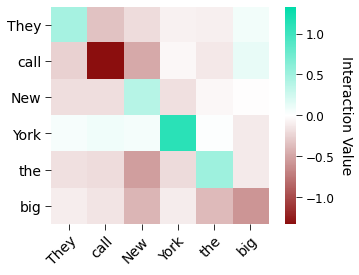

In [ ]:
from path_explain import matrix_interaction_plot

matrix_interaction_plot(
    interactions[0].detach().numpy().sum(-1),
    sen.split(),
    zero_diagonals=False,
)

# Tensorflow

In [ ]:
from path_explain import EmbeddingExplainerTF, text_plot
import numpy as np
from scipy.special import log_softmax
import tensorflow as tf
from transformers import TFAutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt


tf_model = TFAutoModelForCausalLM.from_pretrained("distilgpt2")
tf_tokenizer = AutoTokenizer.from_pretrained("distilgpt2")


def embedding_model(batch_ids):
    batch_embedding = tf_model.transformer.wte(batch_ids)
    return batch_embedding


def prediction_model(batch_embedding):
    if isinstance(batch_embedding, np.ndarray):
        batch_embedding = tf.convert_to_tensor(batch_embedding)
    logits = tf_model(None, inputs_embeds=batch_embedding).logits[:, -1]
    probs = tf.nn.log_softmax(logits, axis=-1)

    return probs


all_attr = []

full_sen = "They call New York the Big"
out = "ĠApple"

print(tf_tokenizer.tokenize(full_sen))

for idx in range(len(full_sen.split()), len(full_sen.split())+1):
    sen = " ".join(full_sen.split()[:idx])

    batch_input = tf_tokenizer([sen])
    batch_ids = batch_input['input_ids']
    batch_embedding = embedding_model(batch_ids)

    baseline_embedding = np.zeros_like(batch_embedding)

    output_idx = tf_tokenizer.convert_tokens_to_ids(out)

    explainer = EmbeddingExplainerTF(prediction_model)
    attributions = explainer.attributions(
        batch_embedding,
        baseline_embedding,
        output_indices=output_idx,
        num_samples=30,
        batch_size=1,
        use_expectation=False,
    )

    logit = prediction_model(batch_embedding)[0, output_idx].numpy()
    baseline_output = prediction_model(baseline_embedding)[0, output_idx].numpy()

    print("logit", logit)
    print("attributions", attributions)
    print("sum", sum(attributions[0]))
    print("baseline", baseline_output)
    print("diff", sum(attributions[0])-(logit-baseline_output))

    text_plot(
        sen.split() + [f"{logit:.2f}"],
        attributions[0].tolist() + [logit],
    )
    plt.show()

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


['They', 'Ġcall', 'ĠNew', 'ĠYork', 'Ġthe', 'ĠBig']
logit -1.9081895
attributions [[ 0.94580823 -0.44317928  1.49607217  1.492033   -0.6304422   5.14608812]]
sum 8.006380051374435
baseline -10.116768
diff -0.2021980583667755


In [ ]:
batch_embedding, baseline_embedding

(<tf.Tensor: shape=(1, 6, 768), dtype=float32, numpy=
 array([[[ 0.00427782, -0.04281095,  0.08497927, ..., -0.18572907,
          -0.00663658,  0.09127836],
         [-0.01042679, -0.11828714,  0.27737835, ...,  0.02839764,
           0.01829186, -0.18716957],
         [-0.14911385, -0.02701931,  0.19814098, ..., -0.19549231,
           0.06978033, -0.1610369 ],
         [-0.0726658 , -0.00557622,  0.24603659, ..., -0.10872955,
           0.20433503, -0.04127118],
         [-0.07323239,  0.01825453,  0.02313236, ..., -0.06644281,
           0.07042494, -0.06527912],
         [-0.1576324 ,  0.02972503,  0.14177276, ..., -0.13400798,
           0.02796467,  0.05287449]]], dtype=float32)>,
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32))

In [ ]:
interactions = explainer.interactions(
    batch_embedding,
    baseline_embedding,
    output_indices=output_idx,
    num_samples=100,
    batch_size=50,
    use_expectation=False,
    verbose=False,
)

100%|██████████| 2/2 [00:36<00:00, 18.42s/it]


(<AxesSubplot:xlabel='Interaction Value', ylabel='Strongest Interacting Pairs'>,
 <Axes:>)

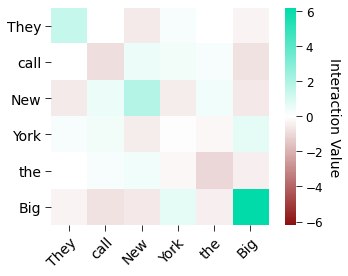

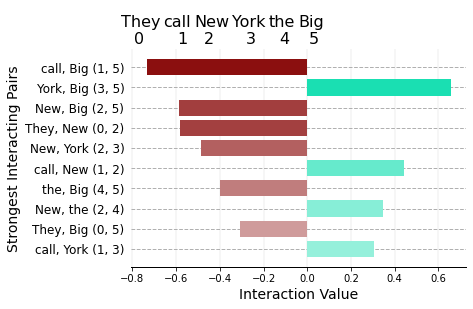

In [ ]:
from path_explain import matrix_interaction_plot, bar_interaction_plot

matrix_interaction_plot(
    interactions[0],
    sen.split(),
    zero_diagonals=False,
)

bar_interaction_plot(
    interactions[0],
    sen.split(),
    top_k=10,
    zero_diagonals=True,
)

In [ ]:
from tqdm import *

mses = []
mse = lambda A, B: ((A - B)**2).mean(axis=-1)

for i in trange(1,11):
    attributions = explainer.attributions(
        batch_embedding,
        baseline_embedding,
        output_indices=output_idx,
        num_samples=i*10,
        use_expectation=False,
    )

    interactions = explainer.interactions(
        batch_embedding,
        baseline_embedding,
        output_indices=output_idx,
        num_samples=i*10,
        batch_size=100,
        use_expectation=False,
        verbose=False,
    )
    print(i*10, mse(attributions, interactions.sum(-1)))
    mses.append(mse(attributions, interactions.sum(-1)))

 10%|█         | 1/10 [00:20<03:04, 20.54s/it]

10 [16.57220728]



 20%|██        | 2/10 [00:43<02:49, 21.13s/it]

20 [0.82457361]



 30%|███       | 3/10 [01:09<02:39, 22.84s/it]

30 [2.09895737]



 40%|████      | 4/10 [01:40<02:31, 25.28s/it]

40 [1.31365409]



  0%|          | 0/1 [00:00<?, ?it/s]


 50%|█████     | 5/10 [02:20<02:27, 29.51s/it]

50 [0.85697252]



  0%|          | 0/1 [00:00<?, ?it/s]


 60%|██████    | 6/10 [03:05<02:16, 34.24s/it]

60 [0.2698558]



 70%|███████   | 7/10 [03:46<01:49, 36.37s/it]

70 [2.17938135]



 80%|████████  | 8/10 [04:31<01:18, 39.01s/it]

80 [1.01939998]



 90%|█████████ | 9/10 [05:20<00:41, 41.91s/it]

90 [0.23753148]



100%|██████████| 10/10 [06:11<00:00, 37.19s/it]

100 [0.14613806]


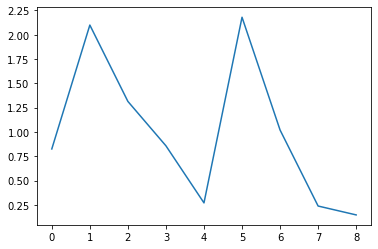

In [ ]:
import matplotlib.pyplot as plt

plt.plot(mses[1:])

In [ ]:
print(attributions)

print(attributions.sum(), interactions.sum())

interactions.sum(-1)

[[0.90857565 0.70387477 0.89427251 5.82610035 1.41065097]]
9.743474245071411 8.278649590909481


array([[0.7441911 , 0.48286861, 0.52309201, 5.25344126, 1.27505662]])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


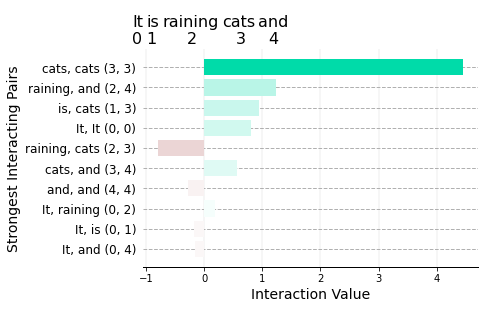

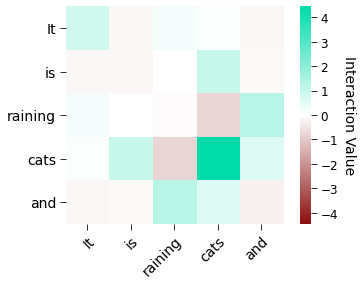

In [ ]:
%load_ext autoreload
%autoreload 2

from path_explain import matrix_interaction_plot, bar_interaction_plot

text_plot(
    sen.split(),
    attributions[0],
)

bar_interaction_plot(
    interactions[0],
    sen.split(),
    top_k=10,
    zero_diagonals=False,
)
plt.show()

matrix_interaction_plot(interactions[0],
                        sen.split(),
                        zero_diagonals=False,
                       )

plt.show()

In [ ]:
print(np.round(interactions, 2),"\n")
print(np.round(interactions.sum(-1), 2),"\n")
print(np.round(attributions, 2),"\n")

mse = lambda A, B: ((A - B)**2).mean(axis=-1)
print(mse(attributions, interactions.sum(-1)))

[[[ 0.8  -0.17  0.19  0.07 -0.15]
  [-0.17 -0.14 -0.03  0.95 -0.12]
  [ 0.19 -0.03 -0.09 -0.79  1.24]
  [ 0.07  0.95 -0.79  4.45  0.57]
  [-0.15 -0.12  1.24  0.57 -0.27]]] 

[[0.74 0.48 0.52 5.25 1.28]] 

[[0.91 0.7  0.89 5.83 1.41]] 

[0.11199305]


In [ ]:
from scipy.sparse.csgraph import minimum_spanning_tree

mst = minimum_spanning_tree(
    np.triu(-interactions.squeeze())
).toarray()

mst[mst!=0.] = 1


def mst_edges(mst):
    edges = set()

    for i in range(mst.shape[0]):
        for j in range(i, mst.shape[0]):
            if mst[i, j] == 1 or mst[j, i] == 1:
                edges.add((i+1, j+1))

    return edges


def print_tikz(predicted_edges, gold_edges, words):
    string = """\\begin{dependency}[hide label, edge unit distance=.5ex]
    \\begin{deptext}[column sep=0.05cm]
    """
    string += (
        "\\& ".join([x.replace("$", "\$").replace("&", "+") for x in words])
        + " \\\\\n"
    )
    string += "\\end{deptext}" + "\n"
#     for i_index, j_index in gold_edges:
#         string += "\\depedge[-]{{{}}}{{{}}}{{{}}}\n".format(i_index, j_index, ".")
    for i_index, j_index in predicted_edges:
        string += f"\\depedge[-,edge style={{red!60!}}, edge below]{{{i_index}}}{{{j_index}}}{{.}}\n"
    string += "\\end{dependency}\n"
    print(string)


edges = mst_edges(mst)

print_tikz(edges, None, sen.split())

\begin{dependency}[hide label, edge unit distance=.5ex]
    \begin{deptext}[column sep=0.05cm]
    John\& is\& eating\& pasta\& with\& a\& fork \\
\end{deptext}
\depedge[-,edge style={red!60!}, edge below]{1}{2}{.}
\depedge[-,edge style={red!60!}, edge below]{4}{6}{.}
\depedge[-,edge style={red!60!}, edge below]{2}{3}{.}
\depedge[-,edge style={red!60!}, edge below]{6}{7}{.}
\depedge[-,edge style={red!60!}, edge below]{4}{5}{.}
\depedge[-,edge style={red!60!}, edge below]{3}{6}{.}
\end{dependency}



# Captum

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization
import torch.nn as nn
import torch


model = AutoModelForCausalLM.from_pretrained("distilgpt2")
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")


class NextTokenPredictor(nn.Module):
    def __init__(self, model):
        super().__init__()

        self.model = model

    def forward(self, input_ids):
#         _, all_hidden_states = self.model(input_ids=input_ids)

#         final_hidden_state = all_hidden_states[:, -1, :]
#         final_logits = self.model.decoder(final_hidden_state)
#         final_probs = torch.log_softmax(final_logits, dim=-1)

        logits = model(input_ids=input_ids).logits[:, -1]
        probs = torch.log_softmax(logits, dim=-1)

        return probs


def add_zero_entry(model):
    weight = model.transformer.wte.weight.data

    if len(tokenizer) == model.transformer.wte.num_embeddings:
        model.transformer.wte.weight.data = torch.cat((weight, torch.zeros(1, weight.shape[-1])))
        model.transformer.wte.num_embeddings += 1


add_zero_entry(model)
custom_model = NextTokenPredictor(model)

attributor = LayerIntegratedGradients(custom_model, custom_model.model.transformer.wte)

sen = "It is raining cats and"
out = "dogs"

batch_ids = tokenizer([sen])['input_ids']
output_idx = torch.tensor([tokenizer.convert_tokens_to_ids(f"Ġ{out}")])

token_reference = TokenReferenceBase(reference_token_idx=len(tokenizer))
baseline = token_reference.generate_reference(len(batch_ids[0]), device="cpu").unsqueeze(0)


ig_attribution = attributor.attribute(
    torch.tensor(batch_ids),
    baselines=baseline,
    target=output_idx.item(),
    n_steps=100,
    method="riemann_trapezoid",
)

ig_attribution = ig_attribution.sum(-1).squeeze()

print(ig_attribution)

vis_records = [
    visualization.VisualizationDataRecord(
        ig_attribution / max(abs(ig_attribution)),
        0,
        out,
        "",
        "",
        0,
        sen.split(),
        None
    )
    for idx, attr in enumerate(ig_attribution)
]

visualization.visualize_text(vis_records)

tensor([ 12.3867, -14.1301,  -3.2967,  13.4059,  -2.6396])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
,dogs (0.00),,0.00,It is raining cats and
,dogs (0.00),,0.00,It is raining cats and
,dogs (0.00),,0.00,It is raining cats and
,dogs (0.00),,0.00,It is raining cats and
,dogs (0.00),,0.00,It is raining cats and


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
,dogs (0.00),,0.00,It is raining cats and
,dogs (0.00),,0.00,It is raining cats and
,dogs (0.00),,0.00,It is raining cats and
,dogs (0.00),,0.00,It is raining cats and
,dogs (0.00),,0.00,It is raining cats and


In [ ]:
logits = model(input_ids=torch.tensor(batch_ids)).logits[0,-1,:]
# custom_model(input_ids=torch.tensor(batch_ids))

torch.softmax(logits, dim=0), torch.exp(logits).sum()

(tensor([1.1204e-27, 1.0745e-27, 2.3760e-29,  ..., 3.8551e-29, 1.8706e-28,
         1.0000e+00], grad_fn=<SoftmaxBackward>),
 tensor(1., grad_fn=<SumBackward0>))

In [ ]:
model(input_ids=torch.tensor(batch_ids)).logits.shape
model(inputs_embeds=model.transformer.wte.weight[batch_ids]).logits

tensor([[-32.8619, -30.7633, -32.5626,  ..., -43.7029, -32.9935,   0.0000],
        [-62.3421, -63.0430, -67.7622,  ..., -69.7235, -66.4648,   0.0000],
        [-68.8666, -70.9159, -77.1711,  ..., -81.3696, -73.7653,   0.0000],
        [-66.0321, -68.8186, -72.7003,  ..., -77.8690, -72.5476,   0.0000],
        [-62.0561, -62.0979, -65.9096,  ..., -65.4256, -63.8461,   0.0000]],
       grad_fn=<MmBackward>)

In [ ]:
def prediction_model(batch_embedding):
    logits = model(inputs_embeds=batch_embedding).logits[:, -1]
    probs = torch.log_softmax(logits, dim=-1)

    return probs


inp = torch.zeros((1,5,768))
prediction_model(inp).squeeze().exp()[:-1].sum()

tensor(4.2525e-21, grad_fn=<SumBackward0>)

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer


#!/usr/bin/env python
import functools
import operator
import torch
from torch.autograd import grad
import numpy as np
from tqdm import *

def gather_nd(params, indices):
    """
    Args:
        params: Tensor to index
        indices: k-dimension tensor of integers.
    Returns:
        output: 1-dimensional tensor of elements of ``params``, where
            output[i] = params[i][indices[i]]

            params   indices   output

            1 2       1 1       4
            3 4       2 0 ----> 5
            5 6       0 0       1
    """
    max_value = functools.reduce(operator.mul, list(params.size())) - 1
    indices = indices.t().long()
    ndim = indices.size(0)
    idx = torch.zeros_like(indices[0]).long()
    m = 1

    for i in range(ndim)[::-1]:
        idx += indices[i]*m
        m *= params.size(i)

    idx[idx < 0] = 0
    idx[idx > max_value] = 0
    return torch.take(params, idx)

class PathExplainerTorch(object):
    def __init__(self, model):
        self.model = model
        return

    def _get_ref_tensor(self,baseline,batch_size,num_samples):
        number_to_draw = num_samples * batch_size
        replace = baseline.shape[0] < number_to_draw
        sample_indices = np.random.choice(baseline.shape[0],
                                          size=number_to_draw,
                                          replace=replace)
        ref_tensor = baseline[sample_indices,:]

        return ref_tensor

    def _get_samples_input(self, input_tensor, baseline,
                           num_samples, use_expectation):
        '''
        calculate interpolation points
        Args:
            input_tensor: Tensor of shape (batch, ...), where ... indicates
                          the input dimensions.
            reference_tensor: A tensor of shape (batch, k, ...) where ...
                indicates dimensions, and k represents the number of background
                reference samples to draw per input in the batch.
        Returns:
            samples_input: A tensor of shape (batch, k, ...) with the
                interpolated points between input and ref.
            samples_delta: A tensor of shape (batch, 1, ...) with the
                difference between input and reference for each sample
        '''
        input_dims = list(input_tensor.size())[1:]
        num_input_dims = len(input_dims)
        batch_size = input_tensor.size()[0]

        if use_expectation:
            reference_tensor = self._get_ref_tensor(baseline,batch_size,num_samples)
            shape = reference_tensor.shape
            reference_tensor = reference_tensor.view(
                    batch_size,
                    num_samples,
                    *(shape[1:]))

            # Grab a [batch_size, k]-sized interpolation sample
            t_tensor = torch.FloatTensor(batch_size, num_samples).uniform_(0,1).to(reference_tensor.device)
            shape = [batch_size, num_samples] + [1] * num_input_dims
            interp_coef = t_tensor.view(*shape)

            # Evaluate the end points
            end_point_ref = (1.0 - interp_coef) * reference_tensor

            input_expand_mult = input_tensor.unsqueeze(1)
            end_point_input = interp_coef * input_expand_mult

            # Affine Combine
            samples_input = end_point_input + end_point_ref

        else:
            batch_size = input_tensor.size()[0]
            input_expand = input_tensor.unsqueeze(1)
            reps = np.ones(len(baseline.shape)).astype(int)
            reps[0] = batch_size
            reference_tensor = baseline.repeat(list(reps)).unsqueeze(1)
#             reference_tensor = torch.as_tensor(sampled_baseline).unsqueeze(1).to(baseline.device)
            scaled_inputs = [reference_tensor + (float(i)/(num_samples-1))*(input_expand - reference_tensor) \
                             for i in range(0,num_samples)]
            samples_input = torch.cat(scaled_inputs,dim=1)

        samples_delta = self._get_samples_delta(input_tensor, reference_tensor)
        samples_delta = samples_delta.to(samples_input.device)

        return samples_input, samples_delta

    def _get_samples_delta(self, input_tensor, reference_tensor):
        input_expand_mult = input_tensor.unsqueeze(1)
        sd = input_expand_mult - reference_tensor
        return sd

    def _get_grads(self, samples_input, output_indices=None):

        grad_tensor = torch.zeros(samples_input.shape).float().to(samples_input.device)

        k_ = samples_input.shape[1]

        for i in range(k_):
            particular_slice = samples_input[:,i]
            batch_output = self.model(particular_slice)
            # should check that users pass in sparse labels
            # Only look at the user-specified label
            if batch_output.size(1) > 1:
                sample_indices = torch.arange(0,batch_output.size(0)).to(samples_input.device)
                indices_tensor = torch.cat([
                        sample_indices.unsqueeze(1),
                        output_indices.unsqueeze(1)], dim=1)
                batch_output = gather_nd(batch_output, indices_tensor)

            model_grads = grad(
                    outputs=batch_output,
                    inputs=particular_slice,
                    grad_outputs=torch.ones_like(batch_output).to(samples_input.device),
                    create_graph=True)
            grad_tensor[:,i,:] = model_grads[0]
        return grad_tensor

    def attributions(self, input_tensor, baseline,
                     num_samples = 50, use_expectation=True,
                     output_indices=None):
        """
        Calculate either Expected or Integrated Gradients approximation of
        Aumann-Shapley values for the sample ``input_tensor``.

        Args:
            model (torch.nn.Module): Pytorch neural network model for which the
                output should be explained.
            input_tensor (torch.Tensor): Pytorch tensor representing the input
                to be explained.
            baseline (torch.Tensor): Pytorch tensor representing the baseline.
                If use_expectation is true, then baseline should be shape
                (num_refs, ...) where ... indicates the dimensionality
                of the input. Otherwise, baseline should be shape (1, ...).
            output_indices (optional, default=None): For multi-class prediction
        """
        equal_dims = baseline.shape[1:] == input_tensor.shape[1:]
        almost_equal_dims = baseline.shape == input_tensor.shape[1:]

        dev = input_tensor.device
        baseline = baseline.to(dev)

        input_tensor.requires_grad_ = True

        if use_expectation and not equal_dims:
            raise ValueError('baseline should be shape (num_refs, ...) \
                              where ... indicates the dimensionality   \
                              of the input')

        if not use_expectation and baseline.shape[0] != 1:
            if almost_equal_dims:
                baseline = baseline.unsqueeze(0)
            else:
                raise ValueError('baseline should be shape (...)           \
                                  where ... indicates the dimensionality   \
                                  of the input')

        samples_input, samples_delta = self._get_samples_input(input_tensor, baseline,
                                                               num_samples, use_expectation)
        grad_tensor = self._get_grads(samples_input, output_indices)
        mult_grads = samples_delta * grad_tensor
        attributions = mult_grads.mean(1)

        return attributions


model = AutoModelForCausalLM.from_pretrained("distilgpt2")
tokenizer = AutoTokenizer.from_pretrained("distilgpt2")


def embedding_model(batch_ids):
    batch_embedding = model.transformer.wte.weight[[batch_ids]]
    return batch_embedding


def prediction_model(batch_embedding):
    logits = model(inputs_embeds=batch_embedding).logits[:, -1]
    probs = torch.log_softmax(logits, dim=-1)

    return probs


sen = "It is raining cats and"
out = "dogs"

batch_input = tokenizer([sen])
batch_ids = batch_input['input_ids']
batch_embedding = embedding_model(batch_ids)

baseline_embedding = torch.zeros_like(batch_embedding)

output_idx = torch.tensor([tokenizer.convert_tokens_to_ids(f"Ġ{out}")])

explainer = PathExplainerTorch(prediction_model)

attributions = explainer.attributions(
    batch_embedding,
    baseline_embedding,
    output_indices=output_idx,
    num_samples=100,
    use_expectation=False,
)

sum_attr = attributions.squeeze().detach().numpy().sum(-1)  # Sum over embedding dim

logit = prediction_model(batch_embedding)[0, output_idx].item()
baseline_output = prediction_model(baseline_embedding)[0, output_idx].item()

print("logit", logit)
print("attributions", sum_attr)
print("sum", sum(sum_attr))
print("diff", logit - baseline_output)


logit -1.2117385864257812
attributions [0.93203324 0.73045576 0.9232333  5.9184027  1.4536085 ]
sum 9.957733452320099
diff 10.046453475952148
